Usando dispositivo: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 8.75MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 299kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.49MB/s]


Epoch [1/20] Batch [0/469] Loss D: 1.4004 Loss G: 0.7242
Epoch [1/20] Batch [200/469] Loss D: 1.1969 Loss G: 1.4040
Epoch [1/20] Batch [400/469] Loss D: 1.2260 Loss G: 0.8262
Epoch [2/20] Batch [0/469] Loss D: 1.2282 Loss G: 1.2163
Epoch [2/20] Batch [200/469] Loss D: 1.2327 Loss G: 0.7961
Epoch [2/20] Batch [400/469] Loss D: 1.2370 Loss G: 0.8666
Epoch [3/20] Batch [0/469] Loss D: 1.3374 Loss G: 0.5305
Epoch [3/20] Batch [200/469] Loss D: 1.3004 Loss G: 0.6807
Epoch [3/20] Batch [400/469] Loss D: 1.2486 Loss G: 0.7397
Epoch [4/20] Batch [0/469] Loss D: 1.3287 Loss G: 0.5097
Epoch [4/20] Batch [200/469] Loss D: 1.4567 Loss G: 1.2424
Epoch [4/20] Batch [400/469] Loss D: 1.3651 Loss G: 0.5165
Epoch [5/20] Batch [0/469] Loss D: 1.2496 Loss G: 0.8811
Epoch [5/20] Batch [200/469] Loss D: 1.3517 Loss G: 0.9747
Epoch [5/20] Batch [400/469] Loss D: 1.2810 Loss G: 0.6291
Epoch [6/20] Batch [0/469] Loss D: 1.2505 Loss G: 0.8155
Epoch [6/20] Batch [200/469] Loss D: 1.3383 Loss G: 0.5353
Epoch [6/

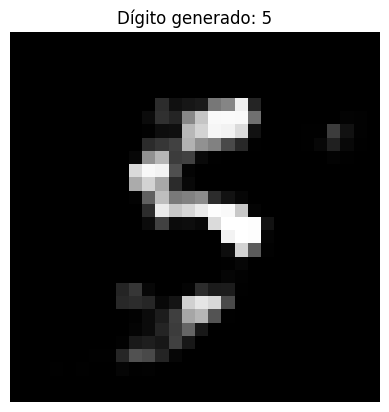

tensor([[[[4.6223e-05, 4.1425e-06, 1.0937e-05,  ..., 4.3809e-06,
           5.7220e-06, 2.1726e-05],
          [5.9605e-07, 2.9802e-08, 1.1921e-07,  ..., 1.1921e-07,
           2.3842e-07, 1.1325e-06],
          [1.4901e-07, 0.0000e+00, 2.9802e-08,  ..., 2.9802e-07,
           1.2517e-06, 2.9504e-06],
          ...,
          [1.9342e-05, 9.6560e-06, 8.9496e-05,  ..., 0.0000e+00,
           2.9802e-08, 2.3842e-07],
          [2.0266e-05, 1.2368e-05, 3.2097e-05,  ..., 2.9802e-08,
           0.0000e+00, 8.3447e-07],
          [9.5397e-05, 1.4064e-04, 1.8129e-04,  ..., 5.9605e-08,
           1.7881e-07, 5.2154e-06]]],


        [[[3.0649e-04, 1.3518e-04, 9.2089e-05,  ..., 6.2954e-04,
           6.9726e-04, 1.0188e-03],
          [1.9282e-05, 4.1723e-07, 1.2517e-06,  ..., 4.5776e-05,
           4.5598e-04, 3.8481e-03],
          [1.2189e-05, 7.7486e-07, 2.9206e-06,  ..., 2.5409e-04,
           6.4190e-03, 1.6749e-02],
          ...,
          [2.1756e-06, 6.2585e-07, 1.6093e-06,  ..., 6.47

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

# ===========================
# 1. Hiperparámetros
# ===========================
latent_dim = 100
num_classes = 10
batch_size = 128
num_epochs = 20
lr = 2e-4
beta1 = 0.5

image_size = 28
image_channels = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

os.makedirs("samples_cgan", exist_ok=True)


# ===========================
# 2. Dataset MNIST
# ===========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [0,1] -> [-1,1]
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


# ===========================
# 3. Modelo: Generador condicional
# ===========================
class ConditionalGenerator(nn.Module):
    """
    Generador G(z, y): toma ruido z y etiqueta y (one-hot) y produce imagen 1x28x28.
    """
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        input_dim = latent_dim + num_classes  # concatenamos z + y(one-hot)

        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256 * 7 * 7),
            nn.BatchNorm1d(256 * 7 * 7),
            nn.ReLU(True)
        )

        self.conv_blocks = nn.Sequential(
            # (256, 7, 7) -> (128, 14, 14)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # (128, 14, 14) -> (1, 28, 28)
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # salida en [-1,1]
        )

    def forward(self, z, y):
        # z: (B, latent_dim)
        # y: (B, num_classes) one-hot
        z_cond = torch.cat((z, y), dim=1)  # (B, latent_dim + num_classes)
        x = self.fc(z_cond)                # (B, 256*7*7)
        x = x.view(-1, 256, 7, 7)          # (B, 256, 7, 7)
        img = self.conv_blocks(x)          # (B, 1, 28, 28)
        return img


# ===========================
# 4. Modelo: Discriminador condicional
# ===========================
class ConditionalDiscriminator(nn.Module):
    """
    Discriminador D(x, y): toma imagen x y etiqueta y (one-hot) y devuelve prob. de "real".
    Usamos un MLP sobre [flatten(x), y].
    """
    def __init__(self, num_classes):
        super().__init__()
        input_dim = image_size * image_size * image_channels + num_classes  # 784 + 10 = 794

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, y):
        # img: (B, 1, 28, 28)
        # y: (B, num_classes) one-hot
        x = img.view(img.size(0), -1)     # (B, 784)
        x_cond = torch.cat((x, y), dim=1) # (B, 784 + 10)
        out = self.model(x_cond)          # (B, 1)
        return out


# ===========================
# 5. Inicialización de modelos
# ===========================
G = ConditionalGenerator(latent_dim, num_classes).to(device)
D = ConditionalDiscriminator(num_classes).to(device)

criterion = nn.BCELoss()
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))


def weights_init_normal(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)


G.apply(weights_init_normal)
D.apply(weights_init_normal)


# ===========================
# 6. Función auxiliar: one-hot de etiquetas
# ===========================
def one_hot(labels, num_classes):
    """
    labels: tensor Long (B,)
    return: (B, num_classes) float
    """
    return F.one_hot(labels, num_classes=num_classes).float()


# ===========================
# 7. Bucle de entrenamiento
# ===========================
fixed_noise = torch.randn(10, latent_dim, device=device)
fixed_labels = torch.arange(0, 10, dtype=torch.long, device=device)  # 0..9
fixed_y = one_hot(fixed_labels, num_classes)

for epoch in range(num_epochs):
    for batch_idx, (real_imgs, labels) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        batch_size_cur = real_imgs.size(0)

        real_y = one_hot(labels, num_classes).to(device)

        # =================================
        # a) Entrenar Discriminador
        # =================================
        D.zero_grad()

        # Etiquetas reales y falsas
        real_targets = torch.ones(batch_size_cur, 1, device=device)
        fake_targets = torch.zeros(batch_size_cur, 1, device=device)

        # --- 1) Pérdida con imágenes reales ---
        out_real = D(real_imgs, real_y)
        loss_D_real = criterion(out_real, real_targets)

        # --- 2) Pérdida con imágenes falsas (condicionadas) ---
        z = torch.randn(batch_size_cur, latent_dim, device=device)
        # Usamos las mismas etiquetas del batch, pero podrían ser otras
        fake_imgs = G(z, real_y)

        out_fake = D(fake_imgs.detach(), real_y)
        loss_D_fake = criterion(out_fake, fake_targets)

        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # =================================
        # b) Entrenar Generador
        # =================================
        G.zero_grad()

        # El generador quiere que D(G(z, y)) ≈ 1
        out_fake_for_G = D(fake_imgs, real_y)
        loss_G = criterion(out_fake_for_G, real_targets)
        loss_G.backward()
        optimizer_G.step()

        # Logging
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Batch [{batch_idx}/{len(train_loader)}] "
                  f"Loss D: {loss_D.item():.4f} "
                  f"Loss G: {loss_G.item():.4f}")

    # ===========================
    # 8. Guardar muestras por epoch (0..9)
    # ===========================
    with torch.no_grad():
        fake_fixed = G(fixed_noise, fixed_y).detach().cpu()
        fake_fixed = (fake_fixed + 1) / 2.0
        utils.save_image(
            fake_fixed,
            f"samples_cgan/epoch_{epoch+1:03d}_digits_0_9.png",
            nrow=10
        )

    # Guardar pesos
    torch.save(G.state_dict(), "cgan_G_mnist.pth")
    torch.save(D.state_dict(), "cgan_D_mnist.pth")

print("Entrenamiento finalizado.")


# ===========================
# 9. Función de inferencia: generar un dígito específico
# ===========================
def generate_digit(generator, digit: int, n_samples: int = 16, save_path=None):
    """
    Genera n_samples imágenes del dígito 'digit' (0-9) usando la cGAN entrenada.
    """
    generator.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim, device=device)
        labels = torch.full((n_samples,), digit, dtype=torch.long, device=device)
        y = one_hot(labels, num_classes).to(device)
        imgs = generator(z, y)        # en [-1,1]
        imgs = (imgs + 1) / 2.0       # a [0,1]

    if save_path is not None:
        utils.save_image(imgs, save_path, nrow=4)
        print(f"Imágenes del dígito {digit} guardadas en {save_path}")

    # Mostrar la primera como ejemplo
    img0 = imgs[0].cpu().squeeze()
    plt.imshow(img0, cmap="gray")
    plt.title(f"Dígito generado: {digit}")
    plt.axis("off")
    plt.show()

    return imgs


# ===========================
# 10. Ejemplo: generar varios "5" al terminar
# ===========================
print("Generando ejemplos del dígito 5...")
generate_digit(G, digit=5, n_samples=16, save_path="samples_cgan/digit_5_example.png")


Generando ejemplos del dígito 0...
Imágenes del dígito 0 guardadas en samples_cgan/digit_0_example.png


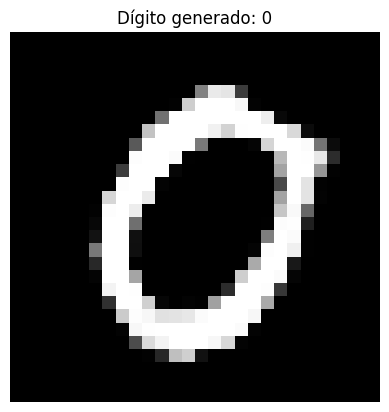

tensor([[[[2.2769e-05, 1.2815e-06, 7.7486e-07,  ..., 2.9802e-08,
           0.0000e+00, 6.5565e-07],
          [1.5497e-06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 5.9605e-08],
          [1.2815e-06, 1.1921e-07, 5.9605e-08,  ..., 0.0000e+00,
           0.0000e+00, 8.9407e-08],
          ...,
          [8.6427e-07, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.3113e-06],
          [1.5497e-06, 2.9802e-08, 0.0000e+00,  ..., 0.0000e+00,
           2.9802e-08, 1.0133e-06],
          [1.0133e-06, 2.9802e-08, 0.0000e+00,  ..., 2.6822e-07,
           5.0664e-07, 6.1095e-06]]],


        [[[5.8949e-05, 7.6592e-06, 4.1723e-07,  ..., 1.3560e-05,
           6.9737e-06, 2.9713e-05],
          [2.5928e-06, 8.9407e-08, 8.9407e-08,  ..., 2.2769e-05,
           2.0266e-05, 1.5417e-04],
          [1.4901e-07, 2.9802e-08, 0.0000e+00,  ..., 1.2454e-04,
           7.6175e-04, 2.0757e-03],
          ...,
          [2.6822e-06, 5.9605e-08, 1.4901e-07,  ..., 2.51

In [17]:
number =0
print(f"Generando ejemplos del dígito {number}...")
generate_digit(G, digit=number, n_samples=16, save_path=f"samples_cgan/digit_{number}_example.png")

In [18]:
torch.save(G.state_dict(), "generator_mnist.pth")
